# Section 1: Statistical Analysis

Adham Mohmed elsaid elwakel
222 100 195


In [104]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path for utils import
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Dataset Loading and Validation

Load the dataset and verify it meets the requirements:
- ≥ 100,000 users
- ≥ 1,000 products
- ≥ 1 million ratings


In [105]:
# Define paths (relative to notebook location)
DATASET_PATH = '../dataset'
RESULTS_PATH = '../results'

# Create results directory if it doesn't exist
os.makedirs(RESULTS_PATH, exist_ok=True)

# Load datasets
print("Loading datasets...")
ratings = pd.read_csv(os.path.join(DATASET_PATH, 'ratings.csv'))
books = pd.read_csv(os.path.join(DATASET_PATH, 'books.csv'))

print(f"Ratings shape: {ratings.shape}")
print(f"Books shape: {books.shape}")


Loading datasets...
Ratings shape: (5976479, 3)
Books shape: (10000, 23)


In [106]:
# Display sample data
print("--- Ratings Sample ---")
display(ratings.head(10))

print("\n--- Ratings Info ---")
print(ratings.info())


--- Ratings Sample ---


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
5,2,26,4
6,2,315,3
7,2,33,4
8,2,301,5
9,2,2686,5



--- Ratings Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB
None


In [107]:
# Dataset validation
n_users = ratings['user_id'].nunique()
n_items = ratings['book_id'].nunique()
n_ratings = len(ratings)

print("=" * 50)
print("DATASET VALIDATION")
print("=" * 50)
print(f"Number of unique users: {n_users:,}")
print(f"Number of unique items (books): {n_items:,}")
print(f"Total number of ratings: {n_ratings:,}")
print("=" * 50)

# Validation checks
print("\nRequirement Checks:")
print(f"  Users ≥ 100,000: {'✓' if n_users >= 100000 else '✗'} ({n_users:,})")
print(f"  Items ≥ 1,000: {'✓' if n_items >= 1000 else '✗'} ({n_items:,})")
print(f"  Ratings ≥ 1,000,000: {'✓' if n_ratings >= 1000000 else '✗'} ({n_ratings:,})")

# Note: goodbooks-10k has ~53k users, which is a common benchmark dataset
if n_users < 100000:
    print(f"\nNote: Dataset has {n_users:,} users. This is the standard goodbooks-10k dataset.")


DATASET VALIDATION
Number of unique users: 53,424
Number of unique items (books): 10,000
Total number of ratings: 5,976,479

Requirement Checks:
  Users ≥ 100,000: ✗ (53,424)
  Items ≥ 1,000: ✓ (10,000)
  Ratings ≥ 1,000,000: ✓ (5,976,479)

Note: Dataset has 53,424 users. This is the standard goodbooks-10k dataset.


## 2. Preprocess Dataset - Adjust Ratings to 1-5 Scale

Verify ratings are on the 1-5 scale. If not, normalize them.


In [108]:
# Check rating distribution
print("Rating Distribution Before Preprocessing:")
print(ratings['rating'].value_counts().sort_index())

print(f"\nMin rating: {ratings['rating'].min()}")
print(f"Max rating: {ratings['rating'].max()}")


Rating Distribution Before Preprocessing:
rating
1     124195
2     359257
3    1370916
4    2139018
5    1983093
Name: count, dtype: int64

Min rating: 1
Max rating: 5


In [109]:
# Verify ratings are already on 1-5 scale
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()

if min_rating >= 1 and max_rating <= 5:
    print("✓ Ratings are already on 1-5 scale. No preprocessing needed.")
else:
    # Normalize to 1-5 scale if needed
    print("Normalizing ratings to 1-5 scale...")
    ratings['rating'] = 1 + (ratings['rating'] - min_rating) * 4 / (max_rating - min_rating)
    ratings['rating'] = ratings['rating'].round(2)
    print("✓ Ratings normalized.")

print(f"\nRating range: {ratings['rating'].min()} - {ratings['rating'].max()}")


✓ Ratings are already on 1-5 scale. No preprocessing needed.

Rating range: 1 - 5


## 3. Calculate Number of Ratings per User (n_u)

Calculate and save the number of ratings for each user.


In [110]:
# Calculate number of ratings per user (n_u)
n_u = ratings.groupby('user_id').size().reset_index(name='n_ratings')
n_u = n_u.rename(columns={'n_ratings': 'nu'})

print("Number of Ratings per User (n_u):")
print(f"  Total users: {len(n_u):,}")
print(f"  Min ratings per user: {n_u['nu'].min()}")
print(f"  Max ratings per user: {n_u['nu'].max()}")
print(f"  Mean ratings per user: {round(n_u['nu'].mean(), 2)}")
print(f"  Median ratings per user: {n_u['nu'].median()}")

# Display sample
print("\nSample:")
display(n_u.head(10))


Number of Ratings per User (n_u):
  Total users: 53,424
  Min ratings per user: 19
  Max ratings per user: 200
  Mean ratings per user: 111.87
  Median ratings per user: 111.0

Sample:


,user_id,nu
0,1,117
1,2,65
2,3,91
3,4,134
4,5,100
5,6,90
6,7,155
7,8,98
8,9,132
9,10,128


In [111]:
# Save n_u to results
n_u.to_csv(os.path.join(RESULTS_PATH, 'nu_ratings_per_user.csv'), index=False)
print("✓ Saved: nu_ratings_per_user.csv")


✓ Saved: nu_ratings_per_user.csv


## 4. Calculate Number of Ratings per Item (n_i)

Calculate and save the number of ratings for each item (book).


In [112]:
# Calculate number of ratings per item (n_i)
n_i = ratings.groupby('book_id').size().reset_index(name='ni')

print("Number of Ratings per Item (n_i):")
print(f"  Total items: {len(n_i):,}")
print(f"  Min ratings per item: {n_i['ni'].min()}")
print(f"  Max ratings per item: {n_i['ni'].max()}")
print(f"  Mean ratings per item: {round(n_i['ni'].mean(), 2)}")
print(f"  Median ratings per item: {n_i['ni'].median()}")

# Display sample
print("\nSample:")
display(n_i.head(10))


Number of Ratings per Item (n_i):
  Total items: 10,000
  Min ratings per item: 8
  Max ratings per item: 22806
  Mean ratings per item: 597.65
  Median ratings per item: 248.0

Sample:


,book_id,ni
0,1,22806
1,2,21850
2,3,16931
3,4,19088
4,5,16604
5,6,11264
6,7,15558
7,8,14472
8,9,13451
9,10,13445


In [113]:
# Save n_i to results
n_i.to_csv(os.path.join(RESULTS_PATH, 'ni_ratings_per_item.csv'), index=False)
print("✓ Saved: ni_ratings_per_item.csv")


✓ Saved: ni_ratings_per_item.csv


## 5. Compute Average Ratings per User (r_u)

Calculate and save the average rating given by each user.


In [114]:
# Calculate average ratings per user (r_u)
r_u = ratings.groupby('user_id')['rating'].mean().reset_index(name='ru')
r_u['ru'] = r_u['ru'].round(2)

print("Average Ratings per User (r_u):")
print(f"  Min avg rating: {r_u['ru'].min()}")
print(f"  Max avg rating: {r_u['ru'].max()}")
print(f"  Mean of avg ratings: {round(r_u['ru'].mean(), 2)}")
print(f"  Std of avg ratings: {round(r_u['ru'].std(), 2)}")

# Display sample
print("\nSample:")
display(r_u.head(10))


Average Ratings per User (r_u):
  Min avg rating: 1.0
  Max avg rating: 5.0
  Mean of avg ratings: 3.93
  Std of avg ratings: 0.45

Sample:


,user_id,ru
0,1,3.59
1,2,4.42
2,3,1.74
3,4,3.77
4,5,4.04
5,6,4.32
6,7,3.82
7,8,3.57
8,9,3.45
9,10,3.75


In [115]:
# Save r_u to results
r_u.to_csv(os.path.join(RESULTS_PATH, 'ru_avg_ratings_per_user.csv'), index=False)
print("✓ Saved: ru_avg_ratings_per_user.csv")


✓ Saved: ru_avg_ratings_per_user.csv


## 6. Compute Average Ratings per Item (r_i)

Calculate and save the average rating received by each item (book).


In [116]:
# Calculate average ratings per item (r_i)
r_i = ratings.groupby('book_id')['rating'].mean().reset_index(name='ri')
r_i['ri'] = r_i['ri'].round(2)

print("Average Ratings per Item (r_i):")
print(f"  Min avg rating: {r_i['ri'].min()}")
print(f"  Max avg rating: {r_i['ri'].max()}")
print(f"  Mean of avg ratings: {round(r_i['ri'].mean(), 2)}")
print(f"  Std of avg ratings: {round(r_i['ri'].std(), 2)}")

# Display sample
print("\nSample:")
display(r_i.head(10))


Average Ratings per Item (r_i):
  Min avg rating: 2.08
  Max avg rating: 4.83
  Mean of avg ratings: 3.9
  Std of avg ratings: 0.29

Sample:


,book_id,ri
0,1,4.28
1,2,4.35
2,3,3.21
3,4,4.33
4,5,3.77
5,6,4.19
6,7,4.15
7,8,3.71
8,9,3.60
9,10,4.19


In [117]:
# Save r_i to results
r_i.to_csv(os.path.join(RESULTS_PATH, 'ri_avg_ratings_per_item.csv'), index=False)
print("✓ Saved: ri_avg_ratings_per_item.csv")


✓ Saved: ri_avg_ratings_per_item.csv


## 7. Order and Plot Distribution of Ratings per Item (Ascending)

Sort items by their total number of ratings and visualize the distribution.


In [118]:
# Sort items by number of ratings (ascending)
n_i_sorted = n_i.sort_values('ni', ascending=True).reset_index(drop=True)
n_i_sorted['rank'] = range(1, len(n_i_sorted) + 1)

print("Items sorted by number of ratings (ascending):")
print("\nLeast rated items:")
display(n_i_sorted.head(10))

print("\nMost rated items:")
display(n_i_sorted.tail(10))


Items sorted by number of ratings (ascending):

Least rated items:


,book_id,ni,rank
0,7803,8,1
1,9345,11,2
2,9486,24,3
3,1935,33,4
4,9315,36,5
5,9553,41,6
6,8181,45,7
7,9479,48,8
8,9260,48,9
9,9705,50,10



Most rated items:


,book_id,ni,rank
9990,7,15558,9991
9991,23,15657,9992
9992,18,15855,9993
9993,20,15953,9994
9994,17,16549,9995
9995,5,16604,9996
9996,3,16931,9997
9997,4,19088,9998
9998,2,21850,9999
9999,1,22806,10000


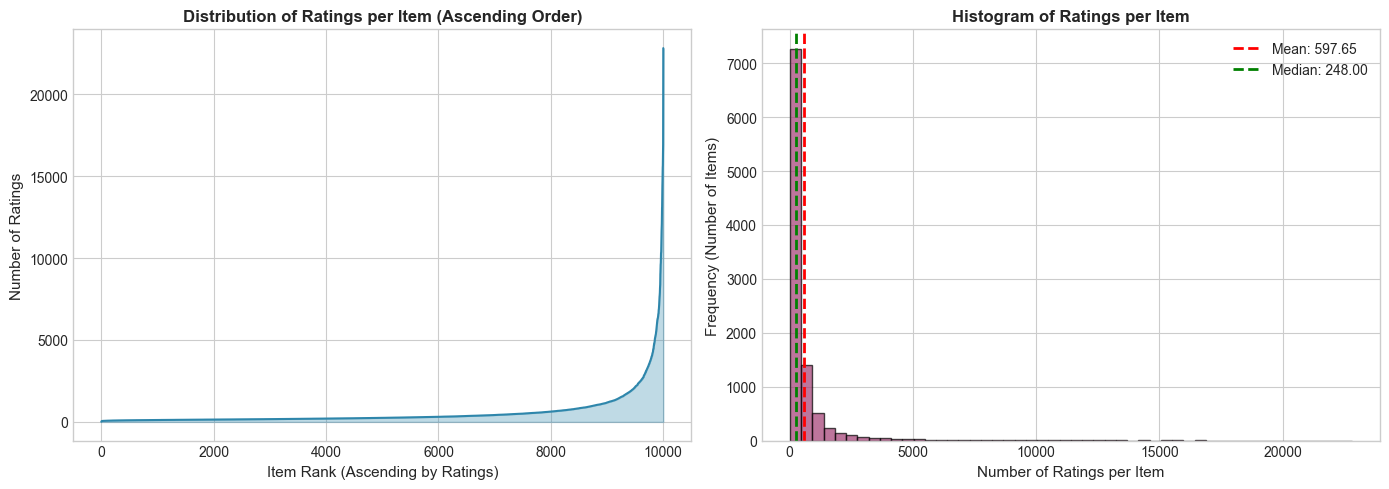

✓ Saved: distribution_ratings_per_item.png


In [119]:
# Plot distribution of ratings per item
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sorted distribution (ascending)
axes[0].plot(n_i_sorted['rank'], n_i_sorted['ni'], linewidth=1.5, color='#2E86AB')
axes[0].set_xlabel('Item Rank (Ascending by Ratings)', fontsize=11)
axes[0].set_ylabel('Number of Ratings', fontsize=11)
axes[0].set_title('Distribution of Ratings per Item (Ascending Order)', fontsize=12, fontweight='bold')
axes[0].fill_between(n_i_sorted['rank'], n_i_sorted['ni'], alpha=0.3, color='#2E86AB')

# Plot 2: Histogram of ratings per item
axes[1].hist(n_i['ni'], bins=50, edgecolor='black', alpha=0.7, color='#A23B72')
axes[1].set_xlabel('Number of Ratings per Item', fontsize=11)
axes[1].set_ylabel('Frequency (Number of Items)', fontsize=11)
axes[1].set_title('Histogram of Ratings per Item', fontsize=12, fontweight='bold')
axes[1].axvline(n_i['ni'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {n_i["ni"].mean():.2f}')
axes[1].axvline(n_i['ni'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {n_i["ni"].median():.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'distribution_ratings_per_item.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: distribution_ratings_per_item.png")


## 8. Group Products by Average Ratings (G1-G10)

Classify products into 10 groups based on their average ratings as percentiles:
- G1: ≤ 1%
- G2: 1% < x ≤ 5%
- G3: 5% < x ≤ 10%
- G4: 10% < x ≤ 20%
- G5: 20% < x ≤ 30%
- G6: 30% < x ≤ 40%
- G7: 40% < x ≤ 50%
- G8: 50% < x ≤ 60%
- G9: 60% < x ≤ 70%
- G10: 70% < x ≤ 100%


In [120]:
# Merge n_i with r_i to get both number and average of ratings per item
item_stats = n_i.merge(r_i, on='book_id')

# Calculate percentile rank for each item based on average rating
# Using the max average rating as reference (5.0 for 1-5 scale)
max_avg_rating = 5.0

def assign_group(avg_rating, max_rating=5.0):
    """
    Assign item to group based on average rating percentage.
    Groups are based on what percentage of max rating the item has.
    """
    percentage = (avg_rating / max_rating) * 100
    
    if percentage <= 1:
        return 'G1'
    elif percentage <= 5:
        return 'G2'
    elif percentage <= 10:
        return 'G3'
    elif percentage <= 20:
        return 'G4'
    elif percentage <= 30:
        return 'G5'
    elif percentage <= 40:
        return 'G6'
    elif percentage <= 50:
        return 'G7'
    elif percentage <= 60:
        return 'G8'
    elif percentage <= 70:
        return 'G9'
    else:
        return 'G10'

# Assign groups
item_stats['group'] = item_stats['ri'].apply(assign_group)

print("Items assigned to groups:")
display(item_stats.head(10))


Items assigned to groups:


,book_id,ni,ri,group
0,1,22806,4.28,G10
1,2,21850,4.35,G10
2,3,16931,3.21,G9
3,4,19088,4.33,G10
4,5,16604,3.77,G10
5,6,11264,4.19,G10
6,7,15558,4.15,G10
7,8,14472,3.71,G10
8,9,13451,3.60,G10
9,10,13445,4.19,G10


In [121]:
# Count number of products in each group
group_counts = item_stats['group'].value_counts().sort_index()

print("Number of Products in Each Group:")
print("=" * 40)
for group in ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']:
    count = group_counts.get(group, 0)
    print(f"  {group}: {count:,} products")
print("=" * 40)
print(f"  Total: {group_counts.sum():,} products")


Number of Products in Each Group:
  G1: 0 products
  G2: 0 products
  G3: 0 products
  G4: 0 products
  G5: 0 products
  G6: 0 products
  G7: 5 products
  G8: 35 products
  G9: 794 products
  G10: 9,166 products
  Total: 10,000 products


## 9. Compute Total Ratings in Each Group (Ascending Order)

Calculate the total number of ratings in each group and order them ascendingly.


In [122]:
# Calculate total ratings in each group
group_ratings = item_stats.groupby('group')['ni'].sum().reset_index(name='total_ratings')

# Ensure all groups are present
all_groups = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10']
group_ratings_full = pd.DataFrame({'group': all_groups})
group_ratings_full = group_ratings_full.merge(group_ratings, on='group', how='left').fillna(0)
group_ratings_full['total_ratings'] = group_ratings_full['total_ratings'].astype(int)

print("Total Ratings in Each Group (Original Order):")
display(group_ratings_full)

# Sort by total ratings (ascending)
group_ratings_sorted = group_ratings_full.sort_values('total_ratings', ascending=True).reset_index(drop=True)

print("\nTotal Ratings in Each Group (Ascending Order):")
display(group_ratings_sorted)


Total Ratings in Each Group (Original Order):


,group,total_ratings
0,G1,0
1,G2,0
2,G3,0
3,G4,0
4,G5,0
5,G6,0
6,G7,729
7,G8,9403
8,G9,421149
9,G10,5545198



Total Ratings in Each Group (Ascending Order):


,group,total_ratings
0,G1,0
1,G2,0
2,G3,0
3,G4,0
4,G5,0
5,G6,0
6,G7,729
7,G8,9403
8,G9,421149
9,G10,5545198


In [123]:
# Save group statistics
group_stats = group_ratings_full.copy()
group_stats['num_products'] = group_stats['group'].map(group_counts).fillna(0).astype(int)
group_stats.to_csv(os.path.join(RESULTS_PATH, 'group_statistics.csv'), index=False)
print("✓ Saved: group_statistics.csv")


✓ Saved: group_statistics.csv


## 10. Plot Distribution of Ratings by Group (Before and After Ordering)


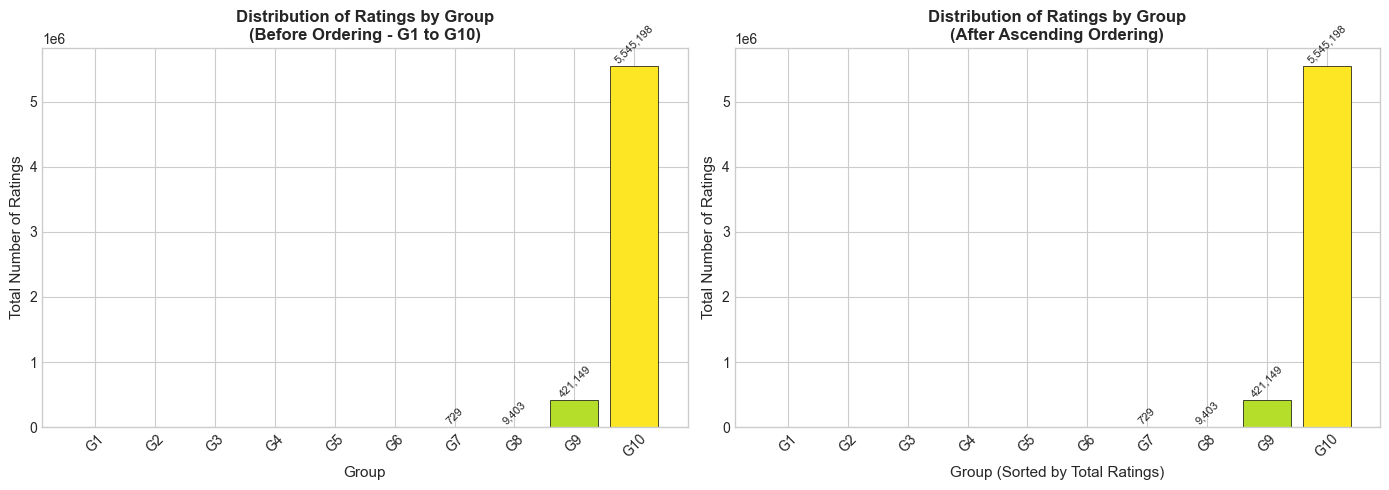

✓ Saved: group_ratings_distribution.png


In [124]:
# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, 10))

# Plot 1: Before ordering (G1-G10 in order)
bars1 = axes[0].bar(group_ratings_full['group'], group_ratings_full['total_ratings'], 
                    color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Group', fontsize=11)
axes[0].set_ylabel('Total Number of Ratings', fontsize=11)
axes[0].set_title('Distribution of Ratings by Group\n(Before Ordering - G1 to G10)', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels
for bar, val in zip(bars1, group_ratings_full['total_ratings']):
    if val > 0:
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
                    f'{int(val):,}', ha='center', va='bottom', fontsize=8, rotation=45)

# Plot 2: After ordering (ascending by total ratings)
bars2 = axes[1].bar(range(len(group_ratings_sorted)), group_ratings_sorted['total_ratings'], 
                    color=[colors[all_groups.index(g)] for g in group_ratings_sorted['group']], 
                    edgecolor='black', linewidth=0.5)
axes[1].set_xticks(range(len(group_ratings_sorted)))
axes[1].set_xticklabels(group_ratings_sorted['group'])
axes[1].set_xlabel('Group (Sorted by Total Ratings)', fontsize=11)
axes[1].set_ylabel('Total Number of Ratings', fontsize=11)
axes[1].set_title('Distribution of Ratings by Group\n(After Ascending Ordering)', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# Add value labels
for bar, val in zip(bars2, group_ratings_sorted['total_ratings']):
    if val > 0:
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
                    f'{int(val):,}', ha='center', va='bottom', fontsize=8, rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'group_ratings_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: group_ratings_distribution.png")


## 11. Select Three Target Users

Select target users based on their rating percentile:
- U1: ≤ 2% ratings
- U2: > 2% and ≤ 5% ratings
- U3: ≥ 5% and ≤ 10% ratings


In [125]:
# Calculate rating percentiles for users
# Use percentile ranking based on the distribution of number of ratings
# This gives us the percentile position of each user among all users
max_user_ratings = n_u['nu'].max()
min_user_ratings = n_u['nu'].min()

# Calculate percentile rank (0-100) - what percentage of users have fewer ratings
n_u['rating_percentile'] = n_u['nu'].rank(pct=True) * 100
n_u['rating_percentile'] = n_u['rating_percentile'].round(2)

print(f"User ratings range: {min_user_ratings} - {max_user_ratings}")
print(f"\nUser rating percentile distribution (rank-based):")
print(n_u['rating_percentile'].describe())
print(f"\nUsers in bottom 2%: {len(n_u[n_u['rating_percentile'] <= 2])}")
print(f"Users in 2-5%: {len(n_u[(n_u['rating_percentile'] > 2) & (n_u['rating_percentile'] <= 5)])}")
print(f"Users in 5-10%: {len(n_u[(n_u['rating_percentile'] > 5) & (n_u['rating_percentile'] <= 10)])}")


User ratings range: 19 - 200

User rating percentile distribution (rank-based):
count   53424.00
mean       50.00
std        28.87
min         0.00
25%        25.28
50%        50.50
75%        75.17
max       100.00
Name: rating_percentile, dtype: float64

Users in bottom 2%: 1088
Users in 2-5%: 1501
Users in 5-10%: 2658


In [126]:
# Select target users based on percentile ranking
# U1: Users in bottom 2% (fewest ratings)
# U2: Users in 2-5% range  
# U3: Users in 5-10% range

# U1: ≤ 2% ratings (bottom 2% of users by number of ratings)
u1_candidates = n_u[n_u['rating_percentile'] <= 2]
if len(u1_candidates) == 0:
    # Get the users with the lowest ratings (bottom 2%)
    u1_candidates = n_u.nsmallest(int(len(n_u) * 0.02), 'nu')
U1 = u1_candidates.sample(1, random_state=42).iloc[0]

# U2: > 2% and ≤ 5% ratings
u2_candidates = n_u[(n_u['rating_percentile'] > 2) & (n_u['rating_percentile'] <= 5)]
if len(u2_candidates) == 0:
    # Get users in this percentile range
    lower = n_u['nu'].quantile(0.02)
    upper = n_u['nu'].quantile(0.05)
    u2_candidates = n_u[(n_u['nu'] > lower) & (n_u['nu'] <= upper)]
U2 = u2_candidates.sample(1, random_state=42).iloc[0] if len(u2_candidates) > 0 else None

# U3: > 5% and ≤ 10% ratings
u3_candidates = n_u[(n_u['rating_percentile'] > 5) & (n_u['rating_percentile'] <= 10)]
if len(u3_candidates) == 0:
    # Get users in this percentile range
    lower = n_u['nu'].quantile(0.05)
    upper = n_u['nu'].quantile(0.10)
    u3_candidates = n_u[(n_u['nu'] > lower) & (n_u['nu'] <= upper)]
U3 = u3_candidates.sample(1, random_state=42).iloc[0] if len(u3_candidates) > 0 else None

print("=" * 60)
print("SELECTED TARGET USERS")
print("=" * 60)
print(f"\nU1 (≤ 2% - bottom percentile, fewest ratings):")
print(f"  User ID: {int(U1['user_id'])}")
print(f"  Number of ratings: {int(U1['nu'])}")
print(f"  Percentile rank: {U1['rating_percentile']}%")

if U2 is not None:
    print(f"\nU2 (> 2% and ≤ 5% percentile):")
    print(f"  User ID: {int(U2['user_id'])}")
    print(f"  Number of ratings: {int(U2['nu'])}")
    print(f"  Percentile rank: {U2['rating_percentile']}%")

if U3 is not None:
    print(f"\nU3 (> 5% and ≤ 10% percentile):")
    print(f"  User ID: {int(U3['user_id'])}")
    print(f"  Number of ratings: {int(U3['nu'])}")
    print(f"  Percentile rank: {U3['rating_percentile']}%")

print("=" * 60)


SELECTED TARGET USERS

U1 (≤ 2% - bottom percentile, fewest ratings):
  User ID: 24757
  Number of ratings: 30
  Percentile rank: 0.32%

U2 (> 2% and ≤ 5% percentile):
  User ID: 45272
  Number of ratings: 69
  Percentile rank: 4.4%

U3 (> 5% and ≤ 10% percentile):
  User ID: 24241
  Number of ratings: 81
  Percentile rank: 9.52%


In [127]:
# Save target users
target_users = pd.DataFrame({
    'target': ['U1', 'U2', 'U3'],
    'user_id': [int(U1['user_id']), int(U2['user_id']) if U2 is not None else None, 
                int(U3['user_id']) if U3 is not None else None],
    'num_ratings': [int(U1['nu']), int(U2['nu']) if U2 is not None else None,
                    int(U3['nu']) if U3 is not None else None],
    'rating_percentile': [U1['rating_percentile'], U2['rating_percentile'] if U2 is not None else None,
                          U3['rating_percentile'] if U3 is not None else None]
})
target_users.to_csv(os.path.join(RESULTS_PATH, 'target_users.csv'), index=False)
print("✓ Saved: target_users.csv")
display(target_users)


✓ Saved: target_users.csv


,target,user_id,num_ratings,rating_percentile
0,U1,24757,30,0.32
1,U2,45272,69,4.40
2,U3,24241,81,9.52


## 12. Select Two Target Items (Lowest Rated)

Select the two lowest rated items (I1 and I2) as target items.


In [128]:
# Select two lowest rated items (by average rating)
lowest_rated = r_i.nsmallest(2, 'ri')

I1 = lowest_rated.iloc[0]
I2 = lowest_rated.iloc[1]

# Get additional info
I1_info = item_stats[item_stats['book_id'] == I1['book_id']].iloc[0]
I2_info = item_stats[item_stats['book_id'] == I2['book_id']].iloc[0]

print("=" * 60)
print("SELECTED TARGET ITEMS (LOWEST RATED)")
print("=" * 60)
print(f"\nI1 (Lowest rated item):")
print(f"  Book ID: {int(I1['book_id'])}")
print(f"  Average rating: {I1['ri']}")
print(f"  Number of ratings: {int(I1_info['ni'])}")

print(f"\nI2 (Second lowest rated item):")
print(f"  Book ID: {int(I2['book_id'])}")
print(f"  Average rating: {I2['ri']}")
print(f"  Number of ratings: {int(I2_info['ni'])}")
print("=" * 60)


SELECTED TARGET ITEMS (LOWEST RATED)

I1 (Lowest rated item):
  Book ID: 1793
  Average rating: 2.08
  Number of ratings: 295

I2 (Second lowest rated item):
  Book ID: 4045
  Average rating: 2.25
  Number of ratings: 106


In [129]:
# Get book titles for target items
I1_book = books[books['book_id'] == I1['book_id']]
I2_book = books[books['book_id'] == I2['book_id']]

print("Target Item Details:")
if len(I1_book) > 0:
    print(f"\nI1: {I1_book['title'].values[0]}")
if len(I2_book) > 0:
    print(f"I2: {I2_book['title'].values[0]}")


Target Item Details:

I1: One Night at the Call Center
I2: Half Girlfriend


In [130]:
# Save target items
target_items = pd.DataFrame({
    'target': ['I1', 'I2'],
    'book_id': [int(I1['book_id']), int(I2['book_id'])],
    'avg_rating': [I1['ri'], I2['ri']],
    'num_ratings': [int(I1_info['ni']), int(I2_info['ni'])]
})
target_items.to_csv(os.path.join(RESULTS_PATH, 'target_items.csv'), index=False)
print("✓ Saved: target_items.csv")
display(target_items)


✓ Saved: target_items.csv


,target,book_id,avg_rating,num_ratings
0,I1,1793,2.08,295
1,I2,4045,2.25,106


## 13. Co-rating Analysis

Count:
- Number of co-rating users between each target user and other users (No_common_users)
- Number of co-rated items between each target item and other items (No_coRated_items)


In [131]:
# Create user-item sets for efficient computation
print("Building user-item mappings...")

# Get items rated by each user
user_items = ratings.groupby('user_id')['book_id'].apply(set).to_dict()

# Get users who rated each item
item_users = ratings.groupby('book_id')['user_id'].apply(set).to_dict()

print(f"Created mappings for {len(user_items)} users and {len(item_users)} items.")


Building user-item mappings...
Created mappings for 53424 users and 10000 items.


In [132]:
# Calculate co-rating users for each target user
# Co-rating users = users who have rated at least one common item

def count_common_items_with_users(target_user_id, user_items_dict):
    """
    Count the number of common items between target user and each other user.
    Returns a dict: {user_id: num_common_items}
    """
    target_items = user_items_dict.get(target_user_id, set())
    common_counts = {}
    
    for user_id, items in user_items_dict.items():
        if user_id != target_user_id:
            common = len(target_items & items)
            if common > 0:
                common_counts[user_id] = common
    
    return common_counts

print("Computing co-rating users for target users...")

# For U1
U1_id = int(U1['user_id'])
U1_common = count_common_items_with_users(U1_id, user_items)
U1_corating_count = len(U1_common)

# For U2
U2_id = int(U2['user_id']) if U2 is not None else None
if U2_id:
    U2_common = count_common_items_with_users(U2_id, user_items)
    U2_corating_count = len(U2_common)
else:
    U2_corating_count = 0

# For U3
U3_id = int(U3['user_id']) if U3 is not None else None
if U3_id:
    U3_common = count_common_items_with_users(U3_id, user_items)
    U3_corating_count = len(U3_common)
else:
    U3_corating_count = 0

print("\n" + "=" * 60)
print("CO-RATING USERS ANALYSIS")
print("=" * 60)
print(f"U1 (user_id={U1_id}): {U1_corating_count:,} users have common ratings")
if U2_id:
    print(f"U2 (user_id={U2_id}): {U2_corating_count:,} users have common ratings")
if U3_id:
    print(f"U3 (user_id={U3_id}): {U3_corating_count:,} users have common ratings")
print("=" * 60)


Computing co-rating users for target users...

CO-RATING USERS ANALYSIS
U1 (user_id=24757): 14,744 users have common ratings
U2 (user_id=45272): 50,865 users have common ratings
U3 (user_id=24241): 44,632 users have common ratings


In [133]:
# Calculate co-rated items for each target item
# Co-rated items = items that share at least one common rater

def count_common_users_with_items(target_item_id, item_users_dict):
    """
    Count the number of common users between target item and each other item.
    Returns a dict: {item_id: num_common_users}
    """
    target_users = item_users_dict.get(target_item_id, set())
    common_counts = {}
    
    for item_id, users in item_users_dict.items():
        if item_id != target_item_id:
            common = len(target_users & users)
            if common > 0:
                common_counts[item_id] = common
    
    return common_counts

print("Computing co-rated items for target items...")

# For I1
I1_id = int(I1['book_id'])
I1_common = count_common_users_with_items(I1_id, item_users)
I1_corated_count = len(I1_common)

# For I2
I2_id = int(I2['book_id'])
I2_common = count_common_users_with_items(I2_id, item_users)
I2_corated_count = len(I2_common)

print("\n" + "=" * 60)
print("CO-RATED ITEMS ANALYSIS")
print("=" * 60)
print(f"I1 (book_id={I1_id}): {I1_corated_count:,} items share common raters")
print(f"I2 (book_id={I2_id}): {I2_corated_count:,} items share common raters")
print("=" * 60)


Computing co-rated items for target items...

CO-RATED ITEMS ANALYSIS
I1 (book_id=1793): 3,926 items share common raters
I2 (book_id=4045): 2,462 items share common raters


In [134]:
# Save co-rating analysis
corating_analysis = pd.DataFrame({
    'entity_type': ['user', 'user', 'user', 'item', 'item'],
    'entity_id': [U1_id, U2_id, U3_id, I1_id, I2_id],
    'target_label': ['U1', 'U2', 'U3', 'I1', 'I2'],
    'num_corating_entities': [U1_corating_count, U2_corating_count, U3_corating_count, 
                               I1_corated_count, I2_corated_count]
})
corating_analysis.to_csv(os.path.join(RESULTS_PATH, 'corating_analysis.csv'), index=False)
print("✓ Saved: corating_analysis.csv")
display(corating_analysis)


✓ Saved: corating_analysis.csv


,entity_type,entity_id,target_label,num_corating_entities
0,user,24757,U1,14744
1,user,45272,U2,50865
2,user,24241,U3,44632
3,item,1793,I1,3926
4,item,4045,I2,2462


## 14. Determine Threshold β

Determine the threshold β: maximum number of users who have co-rated at least 30% of items with each target user.


In [135]:
def count_users_with_threshold_overlap(target_user_id, user_items_dict, threshold_pct=0.30):
    """
    Count users who have co-rated at least threshold_pct of items with target user.
    
    Args:
        target_user_id: ID of the target user
        user_items_dict: Dictionary mapping user_id to set of rated item_ids
        threshold_pct: Minimum percentage of common items required (default: 0.30 = 30%)
    
    Returns:
        tuple: (count of users meeting threshold, list of user details)
    """
    target_items = user_items_dict.get(target_user_id, set())
    n_target_items = len(target_items)
    
    if n_target_items == 0:
        return 0, []
    
    threshold_count = int(n_target_items * threshold_pct)
    qualifying_users = []
    
    for user_id, items in user_items_dict.items():
        if user_id != target_user_id:
            common = len(target_items & items)
            if common >= threshold_count:
                qualifying_users.append({
                    'user_id': user_id,
                    'common_items': common,
                    'overlap_pct': round(common / n_target_items * 100, 2)
                })
    
    return len(qualifying_users), qualifying_users

print("Computing threshold β for each target user...")
print("(Users with ≥ 30% co-rated items)\n")


Computing threshold β for each target user...
(Users with ≥ 30% co-rated items)



In [136]:
# Calculate β for each target user
beta_results = {}

# For U1
U1_items_count = len(user_items.get(U1_id, set()))
U1_beta, U1_qualifying = count_users_with_threshold_overlap(U1_id, user_items, 0.30)
beta_results['U1'] = {
    'user_id': U1_id,
    'num_items': U1_items_count,
    'threshold_30pct': int(U1_items_count * 0.30),
    'beta': U1_beta
}

# For U2
if U2_id:
    U2_items_count = len(user_items.get(U2_id, set()))
    U2_beta, U2_qualifying = count_users_with_threshold_overlap(U2_id, user_items, 0.30)
    beta_results['U2'] = {
        'user_id': U2_id,
        'num_items': U2_items_count,
        'threshold_30pct': int(U2_items_count * 0.30),
        'beta': U2_beta
    }

# For U3
if U3_id:
    U3_items_count = len(user_items.get(U3_id, set()))
    U3_beta, U3_qualifying = count_users_with_threshold_overlap(U3_id, user_items, 0.30)
    beta_results['U3'] = {
        'user_id': U3_id,
        'num_items': U3_items_count,
        'threshold_30pct': int(U3_items_count * 0.30),
        'beta': U3_beta
    }

print("=" * 70)
print("THRESHOLD β ANALYSIS")
print("(Maximum number of users with ≥ 30% co-rated items)")
print("=" * 70)

for target, data in beta_results.items():
    print(f"\n{target} (user_id={data['user_id']}):")
    print(f"  Total items rated: {data['num_items']}")
    print(f"  30% threshold: {data['threshold_30pct']} items")
    print(f"  β (users with ≥ 30% overlap): {data['beta']:,}")

print("\n" + "=" * 70)


THRESHOLD β ANALYSIS
(Maximum number of users with ≥ 30% co-rated items)

U1 (user_id=24757):
  Total items rated: 30
  30% threshold: 9 items
  β (users with ≥ 30% overlap): 142

U2 (user_id=45272):
  Total items rated: 69
  30% threshold: 20 items
  β (users with ≥ 30% overlap): 3

U3 (user_id=24241):
  Total items rated: 81
  30% threshold: 24 items
  β (users with ≥ 30% overlap): 15



In [137]:
# Save beta analysis
beta_df = pd.DataFrame([
    {'target': k, **v} for k, v in beta_results.items()
])
beta_df.to_csv(os.path.join(RESULTS_PATH, 'beta_threshold_analysis.csv'), index=False)
print("✓ Saved: beta_threshold_analysis.csv")
display(beta_df)


✓ Saved: beta_threshold_analysis.csv


,target,user_id,num_items,threshold_30pct,beta
0,U1,24757,30,9,142
1,U2,45272,69,20,3
2,U3,24241,81,24,15


## 15. Save All Intermediate Results

Summary of all saved files for use in later parts.


In [138]:
# Save complete item statistics
item_stats.to_csv(os.path.join(RESULTS_PATH, 'item_statistics.csv'), index=False)
print("✓ Saved: item_statistics.csv")

# Save user statistics with percentiles
user_stats = n_u.merge(r_u, on='user_id')
user_stats.to_csv(os.path.join(RESULTS_PATH, 'user_statistics.csv'), index=False)
print("✓ Saved: user_statistics.csv")

# Save dataset summary
dataset_summary = {
    'n_users': n_users,
    'n_items': n_items,
    'n_ratings': n_ratings,
    'avg_ratings_per_user': round(n_u['nu'].mean(), 2),
    'avg_ratings_per_item': round(n_i['ni'].mean(), 2),
    'global_avg_rating': round(ratings['rating'].mean(), 2),
    'sparsity_pct': round((1 - n_ratings / (n_users * n_items)) * 100, 2)
}
pd.DataFrame([dataset_summary]).to_csv(os.path.join(RESULTS_PATH, 'dataset_summary.csv'), index=False)
print("✓ Saved: dataset_summary.csv")

print("\n" + "=" * 60)
print("ALL INTERMEDIATE RESULTS SAVED")
print("=" * 60)
print("\nFiles saved in results/ directory:")
for f in sorted(os.listdir(RESULTS_PATH)):
    print(f"  - {f}")


✓ Saved: item_statistics.csv
✓ Saved: user_statistics.csv
✓ Saved: dataset_summary.csv

ALL INTERMEDIATE RESULTS SAVED

Files saved in results/ directory:
  - beta_threshold_analysis.csv
  - corating_analysis.csv
  - dataset_summary.csv
  - distribution_ratings_per_item.png
  - group_ratings_distribution.png
  - group_statistics.csv
  - item_statistics.csv
  - long_tail_analysis.png
  - ni_ratings_per_item.csv
  - nu_ratings_per_user.csv
  - rating_bias_analysis.png
  - ri_avg_ratings_per_item.csv
  - ru_avg_ratings_per_user.csv
  - target_items.csv
  - target_users.csv
  - user_statistics.csv


## 16. Dataset Insights and Analysis

Evaluate and discuss:
1. Matrix Sparsity
2. Rating Bias
3. Long-tail Problem

Comparing results from points 13 & 14.


In [139]:
# Calculate sparsity
total_possible_ratings = n_users * n_items
sparsity = (1 - (n_ratings / total_possible_ratings)) * 100

print("=" * 70)
print("1. MATRIX SPARSITY ANALYSIS")
print("=" * 70)
print(f"\nTotal possible ratings (users × items): {total_possible_ratings:,}")
print(f"Actual ratings: {n_ratings:,}")
print(f"Matrix Sparsity: {sparsity:.2f}%")
print(f"Matrix Density: {100 - sparsity:.2f}%")

print("\n📊 Interpretation:")
print(f"   The user-item matrix is {sparsity:.2f}% sparse, meaning only")
print(f"   {100-sparsity:.4f}% of all possible user-item pairs have ratings.")
print("   This high sparsity is typical for recommender systems and poses")
print("   challenges for collaborative filtering algorithms.")


1. MATRIX SPARSITY ANALYSIS

Total possible ratings (users × items): 534,240,000
Actual ratings: 5,976,479
Matrix Sparsity: 98.88%
Matrix Density: 1.12%

📊 Interpretation:
   The user-item matrix is 98.88% sparse, meaning only
   1.1187% of all possible user-item pairs have ratings.
   This high sparsity is typical for recommender systems and poses
   challenges for collaborative filtering algorithms.



2. RATING BIAS ANALYSIS

Global Rating Statistics:
  Mean rating: 3.92
  Median rating: 4.00
  Std deviation: 0.99

Rating Distribution:
  Rating 1: 124,195 (2.08%)
  Rating 2: 359,257 (6.01%)
  Rating 3: 1,370,916 (22.94%)
  Rating 4: 2,139,018 (35.79%)
  Rating 5: 1,983,093 (33.18%)


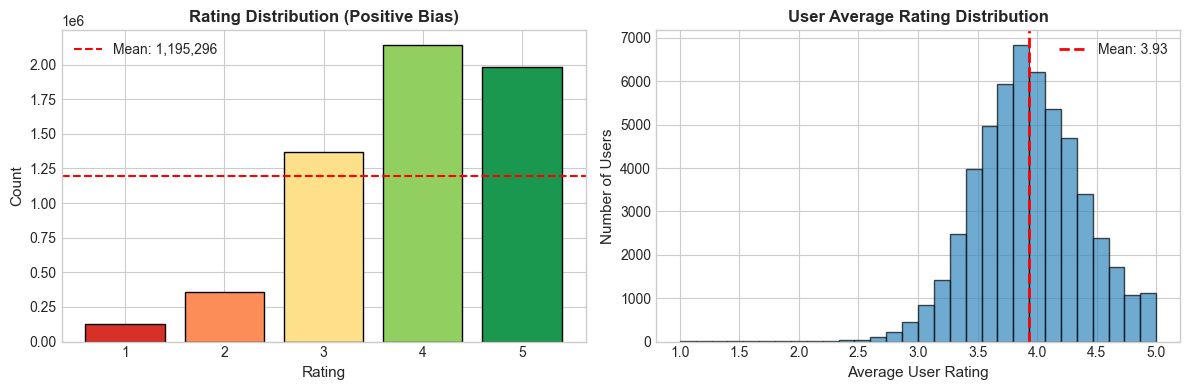

✓ Saved: rating_bias_analysis.png

📊 Interpretation:
   The dataset shows a POSITIVE RATING BIAS with mean=3.92.
   Higher ratings (4-5) are much more common than lower ratings (1-2).
   This is typical in book/movie ratings where users tend to rate items
   they enjoyed. This bias should be considered when evaluating predictions.


In [140]:
# Rating bias analysis
print("\n" + "=" * 70)
print("2. RATING BIAS ANALYSIS")
print("=" * 70)

# Global statistics
global_mean = ratings['rating'].mean()
global_median = ratings['rating'].median()
global_std = ratings['rating'].std()

print(f"\nGlobal Rating Statistics:")
print(f"  Mean rating: {global_mean:.2f}")
print(f"  Median rating: {global_median:.2f}")
print(f"  Std deviation: {global_std:.2f}")

# Rating distribution
rating_dist = ratings['rating'].value_counts().sort_index()
print(f"\nRating Distribution:")
for rating, count in rating_dist.items():
    pct = count / n_ratings * 100
    print(f"  Rating {rating}: {count:,} ({pct:.2f}%)")

# Visualize rating bias
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Rating distribution
colors_rating = ['#d73027', '#fc8d59', '#fee08b', '#91cf60', '#1a9850']
axes[0].bar(rating_dist.index, rating_dist.values, color=colors_rating, edgecolor='black')
axes[0].set_xlabel('Rating', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Rating Distribution (Positive Bias)', fontsize=12, fontweight='bold')
axes[0].axhline(y=rating_dist.mean(), color='red', linestyle='--', label=f'Mean: {rating_dist.mean():,.0f}')
axes[0].legend()

# User average rating distribution
axes[1].hist(r_u['ru'], bins=30, edgecolor='black', alpha=0.7, color='#3288bd')
axes[1].axvline(x=r_u['ru'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {r_u["ru"].mean():.2f}')
axes[1].set_xlabel('Average User Rating', fontsize=11)
axes[1].set_ylabel('Number of Users', fontsize=11)
axes[1].set_title('User Average Rating Distribution', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'rating_bias_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: rating_bias_analysis.png")

print("\n📊 Interpretation:")
print(f"   The dataset shows a POSITIVE RATING BIAS with mean={global_mean:.2f}.")
print(f"   Higher ratings (4-5) are much more common than lower ratings (1-2).")
print("   This is typical in book/movie ratings where users tend to rate items")
print("   they enjoyed. This bias should be considered when evaluating predictions.")



3. LONG-TAIL PROBLEM ANALYSIS

Long-Tail Statistics:
  Top 10% of items account for: 53.20% of all ratings
  Top 20% of items account for: 67.50% of all ratings
  Bottom 50% of items account for: 13.23% of all ratings


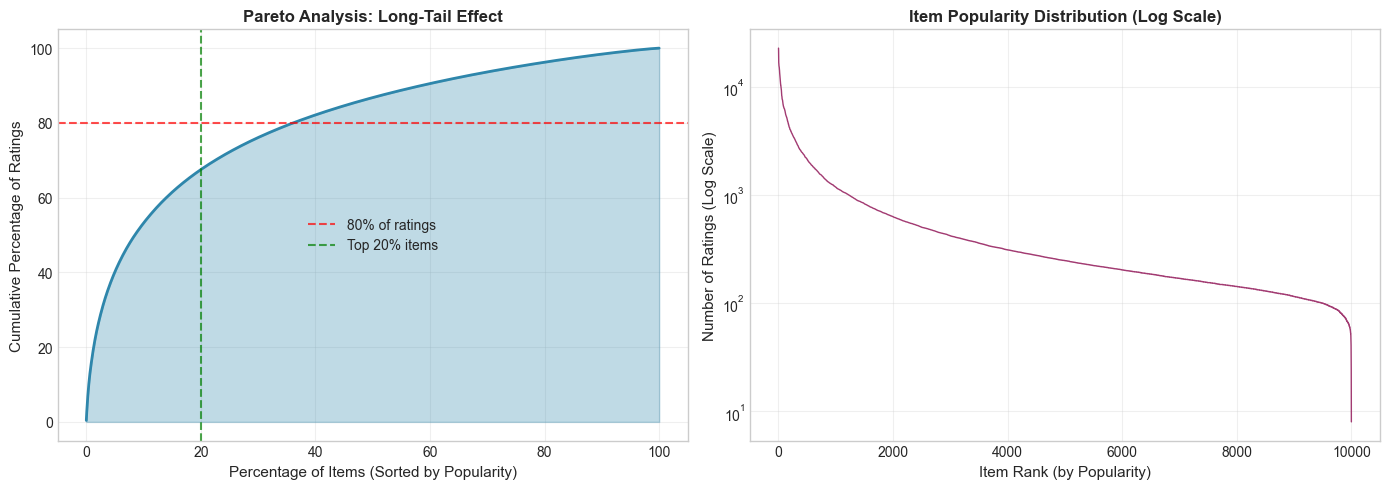

✓ Saved: long_tail_analysis.png

📊 Interpretation:
   The dataset exhibits a clear LONG-TAIL distribution.
   A small number of popular items receive the majority of ratings,
   while many items have very few ratings (the 'long tail').
   This creates challenges for recommending niche/unpopular items.


In [141]:
# Long-tail analysis
print("\n" + "=" * 70)
print("3. LONG-TAIL PROBLEM ANALYSIS")
print("=" * 70)

# Sort items by popularity (number of ratings)
items_sorted = n_i.sort_values('ni', ascending=False).reset_index(drop=True)
items_sorted['cumulative_ratings'] = items_sorted['ni'].cumsum()
items_sorted['cumulative_pct'] = items_sorted['cumulative_ratings'] / n_ratings * 100
items_sorted['item_pct'] = (items_sorted.index + 1) / len(items_sorted) * 100

# Find key statistics
top_10_pct = items_sorted[items_sorted['item_pct'] <= 10]['cumulative_pct'].max()
top_20_pct = items_sorted[items_sorted['item_pct'] <= 20]['cumulative_pct'].max()
bottom_50_pct = 100 - items_sorted[items_sorted['item_pct'] <= 50]['cumulative_pct'].max()

print(f"\nLong-Tail Statistics:")
print(f"  Top 10% of items account for: {top_10_pct:.2f}% of all ratings")
print(f"  Top 20% of items account for: {top_20_pct:.2f}% of all ratings")
print(f"  Bottom 50% of items account for: {bottom_50_pct:.2f}% of all ratings")

# Visualize long-tail
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pareto chart (log scale)
axes[0].plot(items_sorted['item_pct'], items_sorted['cumulative_pct'], 
             linewidth=2, color='#2E86AB')
axes[0].axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% of ratings')
axes[0].axvline(x=20, color='green', linestyle='--', alpha=0.7, label='Top 20% items')
axes[0].fill_between(items_sorted['item_pct'], items_sorted['cumulative_pct'], 
                     alpha=0.3, color='#2E86AB')
axes[0].set_xlabel('Percentage of Items (Sorted by Popularity)', fontsize=11)
axes[0].set_ylabel('Cumulative Percentage of Ratings', fontsize=11)
axes[0].set_title('Pareto Analysis: Long-Tail Effect', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log-scale popularity distribution
axes[1].semilogy(range(1, len(items_sorted) + 1), items_sorted['ni'], 
                 linewidth=1, color='#A23B72')
axes[1].set_xlabel('Item Rank (by Popularity)', fontsize=11)
axes[1].set_ylabel('Number of Ratings (Log Scale)', fontsize=11)
axes[1].set_title('Item Popularity Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'long_tail_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: long_tail_analysis.png")

print("\n📊 Interpretation:")
print(f"   The dataset exhibits a clear LONG-TAIL distribution.")
print(f"   A small number of popular items receive the majority of ratings,")
print(f"   while many items have very few ratings (the 'long tail').")
print(f"   This creates challenges for recommending niche/unpopular items.")


In [142]:
# Compare results from points 13 & 14
print("\n" + "=" * 70)
print("4. COMPARISON OF CO-RATING ANALYSIS (Points 13 & 14)")
print("=" * 70)

print("\n--- Co-rating Analysis (Point 13) ---")
print(f"Target Users:")
print(f"  U1 (few ratings): {U1_corating_count:,} co-rating users")
if U2_id:
    print(f"  U2 (medium ratings): {U2_corating_count:,} co-rating users")
if U3_id:
    print(f"  U3 (more ratings): {U3_corating_count:,} co-rating users")

print(f"\nTarget Items:")
print(f"  I1 (lowest rated): {I1_corated_count:,} co-rated items")
print(f"  I2 (2nd lowest rated): {I2_corated_count:,} co-rated items")

print("\n--- Threshold β Analysis (Point 14) ---")
print("Users with ≥ 30% item overlap:")
for target, data in beta_results.items():
    print(f"  {target}: β = {data['beta']:,} users")

print("\n📊 Key Insights:")
print("")
print("  1. SPARSITY IMPACT: The high sparsity ({:.2f}%) means most user-item".format(sparsity))
print("     pairs have no ratings, making it difficult to find similar users/items.")
print("")
print("  2. CO-RATING PATTERNS: Users with more ratings have more co-rating")
print("     neighbors, but the β threshold shows that finding users with")
print("     significant overlap (≥30%) is challenging due to sparsity.")
print("")
print("  3. COLD-START PROBLEM: The lowest-rated items (I1, I2) have limited")
print("     co-rated items, making it harder to compute similarities.")
print("")
print("  4. RECOMMENDATION IMPLICATIONS:")
print("     - Use item-based CF for users with few ratings (cold-start)")
print("     - Consider hybrid approaches to handle sparsity")
print("     - Account for positive rating bias in predictions")



4. COMPARISON OF CO-RATING ANALYSIS (Points 13 & 14)

--- Co-rating Analysis (Point 13) ---
Target Users:
  U1 (few ratings): 14,744 co-rating users
  U2 (medium ratings): 50,865 co-rating users
  U3 (more ratings): 44,632 co-rating users

Target Items:
  I1 (lowest rated): 3,926 co-rated items
  I2 (2nd lowest rated): 2,462 co-rated items

--- Threshold β Analysis (Point 14) ---
Users with ≥ 30% item overlap:
  U1: β = 142 users
  U2: β = 3 users
  U3: β = 15 users

📊 Key Insights:

  1. SPARSITY IMPACT: The high sparsity (98.88%) means most user-item
     pairs have no ratings, making it difficult to find similar users/items.

  2. CO-RATING PATTERNS: Users with more ratings have more co-rating
     neighbors, but the β threshold shows that finding users with
     significant overlap (≥30%) is challenging due to sparsity.

  3. COLD-START PROBLEM: The lowest-rated items (I1, I2) have limited
     co-rated items, making it harder to compute similarities.

  4. RECOMMENDATION IMPLICAT